In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
plt.style.use('seaborn-v0_8-whitegrid')
import git
import sys
sys.path.append("../")
path_to_root = git.Repo(".", search_parent_directories=True).working_dir
sys.path.append(path_to_root+'/src'+'/')
import functions as f
import load_data as ld
plt.style.use('seaborn-v0_8-whitegrid')

# Bootstraping and Bias Variance tradeoff

In [2]:
# Load the terrain data
terrain_data = imread(path_to_root+"/data/SRTM_data_Norway_1.tif")

# Define the x and y coordinates
x = np.arange(0, terrain_data.shape[1], 10)
y = np.arange(0, terrain_data.shape[0], 10)

/tmp/ipykernel_36114/431384332.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain_data = imread(path_to_root+"/data/SRTM_data_Norway_1.tif")


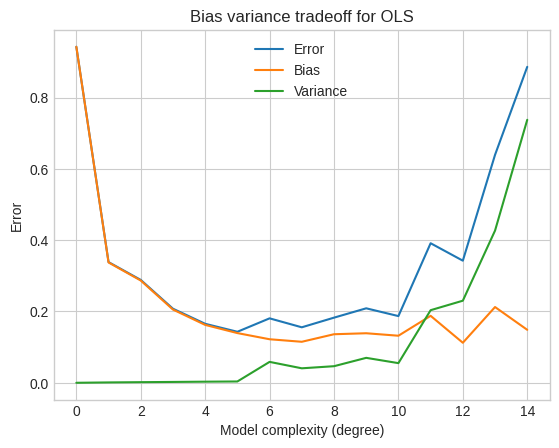

In [3]:
# mangler skalering
n_boostraps = 100
degree = np.arange(0, 15)

# Make data set
x, y, z = ld.load_uniform_data(N_samples = 1000)

errortest = np.zeros(len(degree))
errortrain = np.zeros(len(degree))  
bias = np.zeros(len(degree))
variance = np.zeros(len(degree))

for i in degree:
    # Combine x transformation and model into one operation.
    #X = f.create_design_matrix(x, y, i)
    design_matrix = PolynomialFeatures(degree=i)
    X = design_matrix.fit_transform(np.column_stack((x, y)))

    # Splitting the data into training and test data
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scale and center the data
    X_train, X_test = f.scale_train_test(train = X_train, test = X_test)
    z_train, z_test = f.scale_train_test(train = z_train, test = z_test)

    # Fit the model
    ols = LinearRegression(fit_intercept=False)
    ridge = Ridge(alpha=0.0001, fit_intercept=False)   
    lasso = Lasso(alpha=0.0001, fit_intercept=False)

    model = ols # Change this variable if you want to use another model

    # The following (m x n_bootstraps) matrix holds the column vectors y_pred
    # for each bootstrap iteration.
    z_pred = np.zeros((z_test.shape[0], n_boostraps))

    for j in range(n_boostraps):
        X_, z_ = resample(X_train, z_train)

        # Evaluate the new model on the same test data each time.
        z_pred[:, j] = model.fit(X_, z_).predict(X_test).ravel() 

        # Note: Expectations and variances taken w.r.t. different training
        # data sets, hence the axis=1. Subsequent means are taken across the test data
        # set in order to obtain a total value, but before this we have error/bias/variance
        # calculated per data point in the test set.
        # Note 2: The use of keepdims=True is important in the calculation of bias as this 
        # maintains the column vector form. Dropping this yields very unexpected results.

    errortest[i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    errortrain[i] = np.mean( np.mean((z_train - ols.fit(X_train, z_train).predict(X_train))**2, axis=1, keepdims=True ) ) # modelols.fit(X_train, z_train).predict(X_train))**2 ) ?
    bias[i] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )


plt.title(f'Bias variance tradeoff for OLS')
plt.xlabel('Model complexity (degree)')
plt.ylabel('Error')
plt.plot(degree, errortest, label='Error')
plt.plot(degree, bias, label='Bias')
plt.plot(degree, variance, label='Variance')
plt.legend()
plt.show()


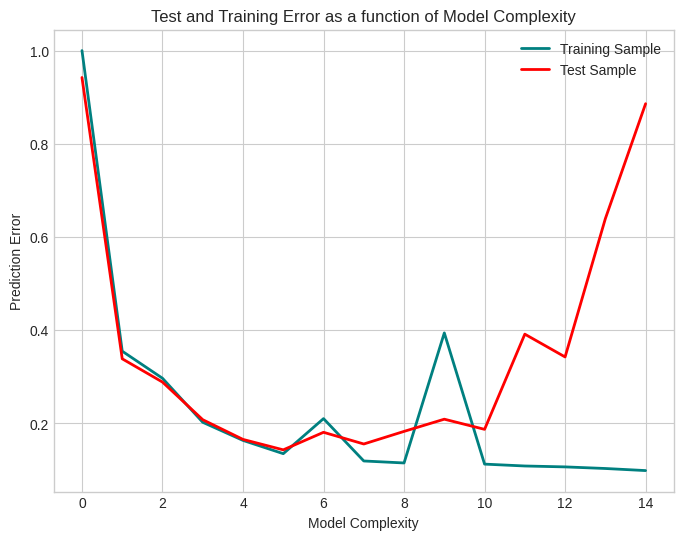

In [4]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(degree, errortrain, label="Training Sample", color='teal', linewidth=2)
plt.plot(degree, errortest, label="Test Sample", color='red', linewidth=2)

# Add labels and title
plt.xlabel("Model Complexity")
plt.ylabel("Prediction Error")
plt.title("Test and Training Error as a function of Model Complexity")

# Add legend
plt.legend()

# Show the plot
plt.show()


# Cross Validation

/home/jonasbaa/Pictures/OneDrive/UiO/Masters degree/Semester 1/FYS-STK4155 Anvendt dataanalyse og maskinlæring/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.139e+00, tolerance: 2.047e-03
  model = cd_fast.enet_coordinate_descent(
/home/jonasbaa/Pictures/OneDrive/UiO/Masters degree/Semester 1/FYS-STK4155 Anvendt dataanalyse og maskinlæring/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.103e+00, tolerance: 2.072e-03
  model = cd_fast.enet_coordinate_descent(
/home/jonasbaa/Pictures/OneDrive/UiO/Masters degree/Semester 1/FYS-STK4155 Anvendt dataana

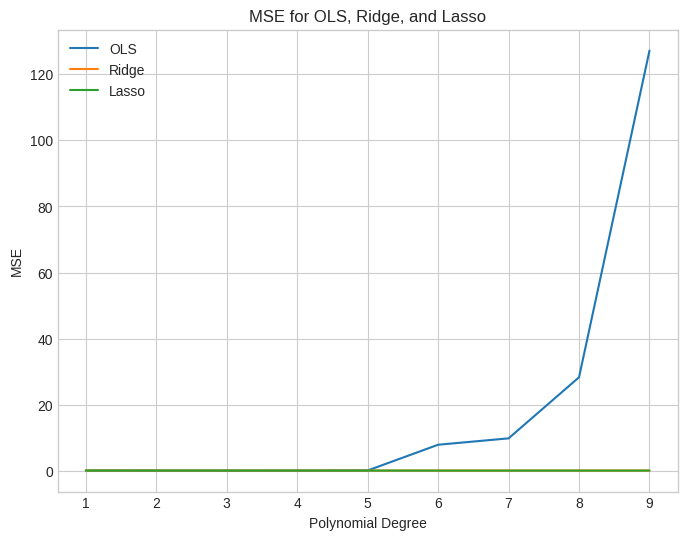

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Load your data (ensure ld.load_uniform_data() is defined)
x, y, z = ld.load_uniform_data()

# Define the range of polynomial degrees to test
degrees = np.arange(1, 10)  # Start from degree 1 to avoid intercept-only model

# Define the number of folds
k_folds = 10

# Initialize arrays to store the MSE values
mse_ols = np.zeros_like(degrees, dtype=float)
mse_ridge = np.zeros_like(degrees, dtype=float)
mse_lasso = np.zeros_like(degrees, dtype=float)

# Define lambda values for Ridge and Lasso
lambda_values = np.logspace(-5, 2, 8)  # From 1e-5 to 1e2

# Perform k-fold cross-validation for each degree
for i, degree in enumerate(degrees):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X = poly_features.fit_transform(np.column_stack((x, y)))

    # No need to scale here; include scaling in the pipeline

    # OLS Model with Pipeline
    pipeline_ols = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression(fit_intercept=False))
    ])
    mse_ols[i] = -np.mean(cross_val_score(pipeline_ols, X, z, cv=k_folds, scoring='neg_mean_squared_error'))

    # Ridge Regression
    mse_temp_ridge = []
    for lambda_val in lambda_values:
        pipeline_ridge = Pipeline([
            ('scaler', StandardScaler()),
            ('model', Ridge(alpha=lambda_val, fit_intercept=False))
        ])
        mse = -np.mean(cross_val_score(pipeline_ridge, X, z, cv=k_folds, scoring='neg_mean_squared_error'))
        mse_temp_ridge.append(mse)
    mse_ridge[i] = np.min(mse_temp_ridge)

    # Lasso Regression
    mse_temp_lasso = []
    for lambda_val in lambda_values:
        pipeline_lasso = Pipeline([
            ('scaler', StandardScaler()),
            ('model', Lasso(alpha=lambda_val, fit_intercept=False, max_iter=10000))
        ])
        mse = -np.mean(cross_val_score(pipeline_lasso, X, z, cv=k_folds, scoring='neg_mean_squared_error'))
        mse_temp_lasso.append(mse)
    mse_lasso[i] = np.min(mse_temp_lasso)

# Plot the MSE values
plt.figure(figsize=(8, 6))
plt.plot(degrees, mse_ols, label='OLS')
plt.plot(degrees, mse_ridge, label='Ridge')
plt.plot(degrees, mse_lasso, label='Lasso')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE for OLS, Ridge, and Lasso')
plt.legend()
plt.show()
